# 1. 라이브러리 불러오기

- 해당 문서는 colab 환경에서 동작
    - 파일 경로
    - 구글 드라이브에 aifactory(압축을 푼 폴더)를 업로드 후 ipynb를 실행하면 경로가 일치하도록 작성되었습니다.
    - 
    ```
    MyDrive
        |_aifactory 폴더
            |_ 2023 제1회 철도 인공지능 경진대회 폴더
                |_ ipynb 폴더
    ```
- Python 3.10.12
- tensorflow                       2.12.0
- numpy                            1.23.5
- pandas                           1.5.3
- matplotlib                       3.7.1
- scikit-learn                     1.2.2
- scipy                            1.10.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/data/data.zip"

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

import pandas as pd
import matplotlib.pyplot as plt

# 시드 고정
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

# 2. 직선 구간 학습

## 2-1. 데이터 불러오기

In [ ]:
# csv load
damper = ['30', '40', '50', '70', '100']

s100 = pd.read_csv("./data_s100.csv")
s70 = pd.read_csv("./data_s70.csv")
s50 = pd.read_csv("./data_s50.csv")
s40 = pd.read_csv("./data_s40.csv")
s30 = pd.read_csv("./data_s30.csv")

In [ ]:
# 직선 선로 데이터
lane = pd.read_csv('./lane_data_s.csv')

In [ ]:
lane

,Distance,Cross level,Curvature,Lateral,Vertical,Gauge
0,0.00,0.081,0.002,1.308,1.155,0.345
1,0.25,0.251,0.002,1.282,1.157,0.151
2,0.50,0.421,0.002,1.256,1.159,-0.043
3,0.75,0.416,0.002,1.297,0.858,0.033
4,1.00,0.412,0.002,1.337,0.558,0.110
...,...,...,...,...,...,...
11995,2998.75,-0.639,-0.002,0.295,-0.503,-0.477
11996,2999.00,-0.827,-0.002,0.299,-0.785,-0.218
11997,2999.25,-0.861,-0.001,0.116,-0.931,-0.048
11998,2999.50,-0.894,0.000,-0.068,-1.077,0.122


In [ ]:
s_col = pd.read_csv('./lane_data_columns.csv', encoding='CP949')

In [ ]:
s_col

,type,name,description
0,curve,Distance,거리[m]
1,curve,Curvature,곡률[1/km]
2,curve,Vertical offset,선로중심부 높이[mm]
3,curve,Cross level offset,캔트[mm]
4,straight,Distance,거리[m]
5,straight,Cross level irregularity,우측 선로에 대한 좌측 선로 높이차(캔트) 불규칙도[mm]
6,straight,Curvature irregularity,곡선에 대한 불규칙도[1/km]
7,straight,Lateral irregularity,수평 불규칙도[mm]
8,straight,Vertical irregularity,수직 불규칙도[mm]
9,straight,Gauge variation,선로 게이지(좌우거리차이) 불규칙도[mm]


In [ ]:
s_columns = dict()

for col in s_col.values:
  t, n, d = col
  if t == 'straight':
    s_columns[n] = d

s_columns

{'Distance': '거리[m]',
 'Cross level irregularity': '우측 선로에 대한 좌측 선로 높이차(캔트) 불규칙도[mm]',
 'Curvature irregularity': '곡선에 대한 불규칙도[1/km]',
 'Lateral irregularity': '수평 불규칙도[mm]',
 'Vertical irregularity': '수직 불규칙도[mm]',
 'Gauge variation': '선로 게이지(좌우거리차이) 불규칙도[mm]'}

In [ ]:
train_col = pd.read_csv('./data_columns.csv')

In [ ]:
train_col

,name,description
0,Distance,거리[m]
1,A_M1_C_B1_Y,대차상부 차체 횡가속도[m/s^2]
2,A_M1_C_B1_Z,대차상부 차체 수직가속도[m/s^2]
3,A_M1_B1_W1_Y_L,좌측 전위 대차 프레임 횡가속도[m/s^2]
4,A_M1_B1_BC_Y_L,좌측 중앙 대차 프레임 횡가속도[m/s^2]
5,A_M1_B1_W2_Y_L,좌측 후위 대차 프레임 횡가속도[m/s^2]
6,A_M1_B1_W1_Y_R,우측 전위 대차 프레임 횡가속도[m/s^2]
7,A_M1_B1_BC_Y_R,우측 중앙 대차 프레임 횡가속도[m/s^2]
8,A_M1_B1_W2_Y_R,우측 후위 대차 프레임 횡가속도[m/s^2]
9,A_M1_B1_W1_Z_L,좌측 전위 대차 프레임 수직가속도[m/s^2]


In [ ]:
columns = dict()

for name, des in zip(train_col['name'].values, train_col['description'].values):
  columns[name] = des

columns

{'Distance': '거리[m]',
 'A_M1_C_B1_Y': '대차상부 차체 횡가속도[m/s^2]',
 'A_M1_C_B1_Z': '대차상부 차체 수직가속도[m/s^2]',
 'A_M1_B1_W1_Y_L': '좌측 전위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_BC_Y_L': '좌측 중앙 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W2_Y_L': '좌측 후위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W1_Y_R': '우측 전위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_BC_Y_R': '우측 중앙 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W2_Y_R': '우측 후위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W1_Z_L': '좌측 전위 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_BC_Z_L': '좌측 중앙 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_W2_Z_L': '좌측 후위 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_W1_Z_R': '우측 전위 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_BC_Z_R': '우측 중앙 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_W2_Z_R': '우측 후위 대차 프레임 수직가속도[m/s^2]',
 'A__B1_W1_Y_A_axle_L': '좌측 전위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W2_Y_A_axle_L': '좌측 후위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W1_Y_A_axle_R': '우측 전위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W2_Y_A_axle_R': '우측 후위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W1_Z_A_axle_L': '좌측 전위 액슬박스 수직가속도[m/s^2]',
 'A__B1_W2_Z_A_axle_L': '좌측 후위 액슬박스 수직가속도[m/s^2]',
 'A__B1_W1_Z_A_axle_R': '우측

In [ ]:
list(columns.values())

['거리[m]',
 '대차상부 차체 횡가속도[m/s^2]',
 '대차상부 차체 수직가속도[m/s^2]',
 '좌측 전위 대차 프레임 횡가속도[m/s^2]',
 '좌측 중앙 대차 프레임 횡가속도[m/s^2]',
 '좌측 후위 대차 프레임 횡가속도[m/s^2]',
 '우측 전위 대차 프레임 횡가속도[m/s^2]',
 '우측 중앙 대차 프레임 횡가속도[m/s^2]',
 '우측 후위 대차 프레임 횡가속도[m/s^2]',
 '좌측 전위 대차 프레임 수직가속도[m/s^2]',
 '좌측 중앙 대차 프레임 수직가속도[m/s^2]',
 '좌측 후위 대차 프레임 수직가속도[m/s^2]',
 '우측 전위 대차 프레임 수직가속도[m/s^2]',
 '우측 중앙 대차 프레임 수직가속도[m/s^2]',
 '우측 후위 대차 프레임 수직가속도[m/s^2]',
 '좌측 전위 액슬박스 횡가속도[m/s^2]',
 '좌측 후위 액슬박스 횡가속도[m/s^2]',
 '우측 전위 액슬박스 횡가속도[m/s^2]',
 '우측 후위 액슬박스 횡가속도[m/s^2]',
 '좌측 전위 액슬박스 수직가속도[m/s^2]',
 '좌측 후위 액슬박스 수직가속도[m/s^2]',
 '우측 전위 액슬박스 수직가속도[m/s^2]',
 '우측 후위 액슬박스 수직가속도[m/s^2]',
 '좌측 전위 차륜 수직하중[kN]',
 '우측 전위 차륜 수직하중[kN]',
 '좌측 전위 차륜 윤중감소율',
 '우측 전위 차륜 윤중감소율',
 '좌측 후위 차륜 수직하중[kN]',
 '우측 후위 차륜 수직하중[kN]',
 '좌측 후위 차륜 윤중감소율',
 '우측 후위 차륜 윤중감소율',
 '좌측 전위 차륜 탈선계수',
 '우측 전위 차륜 탈선계수',
 '좌측 후위 차륜 탈선계수',
 '우측 후위 차륜 탈선계수']

##  탈선 계수
$$\frac{Q}{P}\space P:수직방향, Q:수평방향$$
Q가 P보다 커지면 차륜이 레일을 올라타거나 뛰어넘음

## 2-2. S100 탈선 계수 그래프


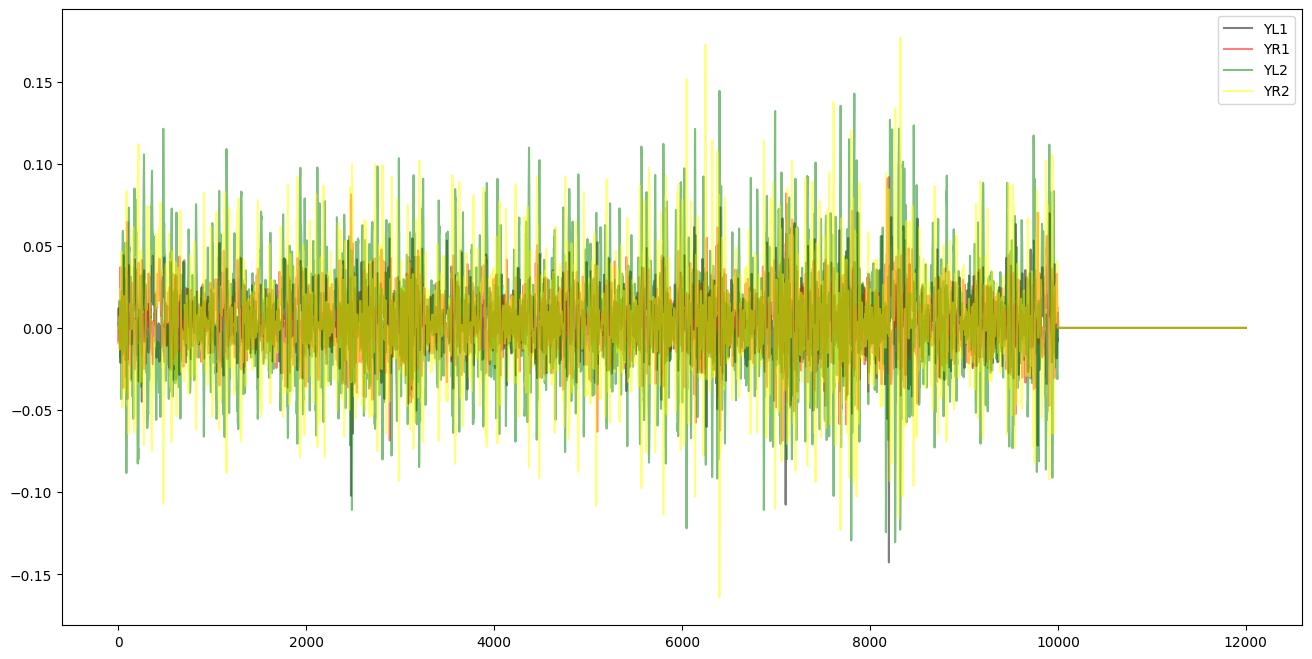

In [ ]:
train100 = pd.merge(left=s100, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X100 = train100.drop(target, axis=1)
y100 = train100.loc[:, target]

plt.figure(figsize=(16,8))

plt.plot(y100.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y100.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y100.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y100.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

## 2-3. S70 탈선 계수 그래프

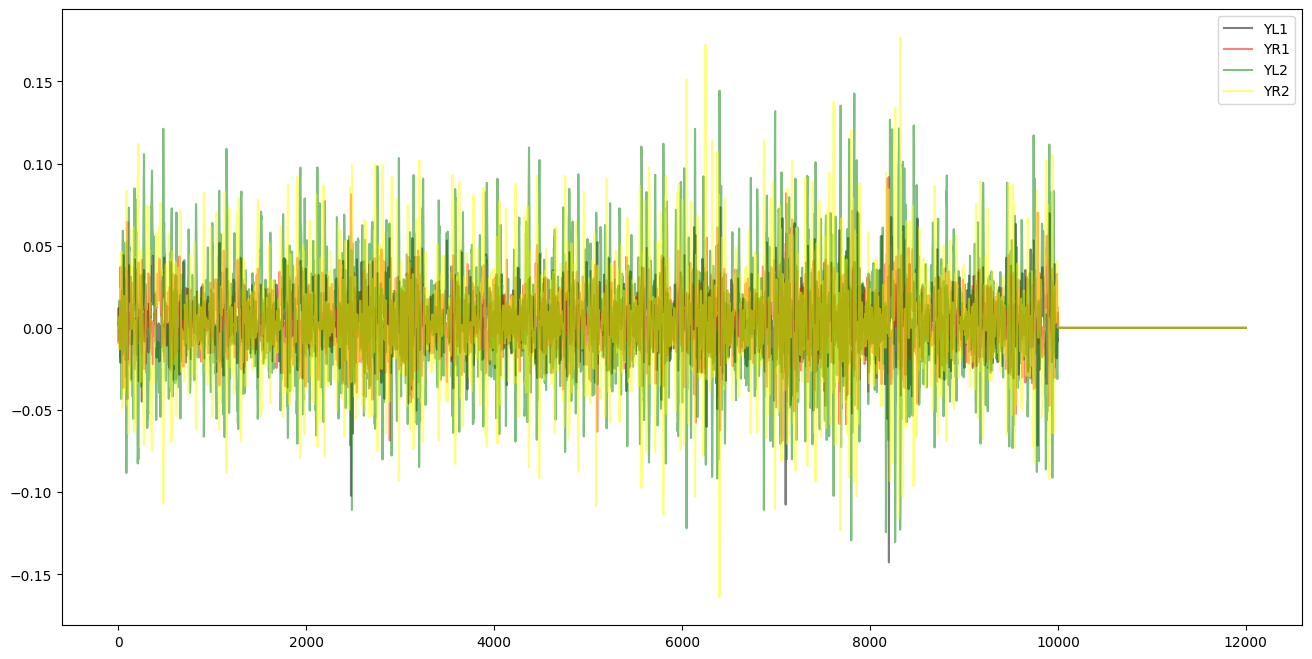

In [ ]:
train70 = pd.merge(left=s70, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X70 = train70.drop(target, axis=1)
y70 = train70.loc[:, target]

plt.figure(figsize=(16,8))

plt.plot(y70.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y70.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y70.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y70.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

## 2-4. S50 탈선 계수 그래프

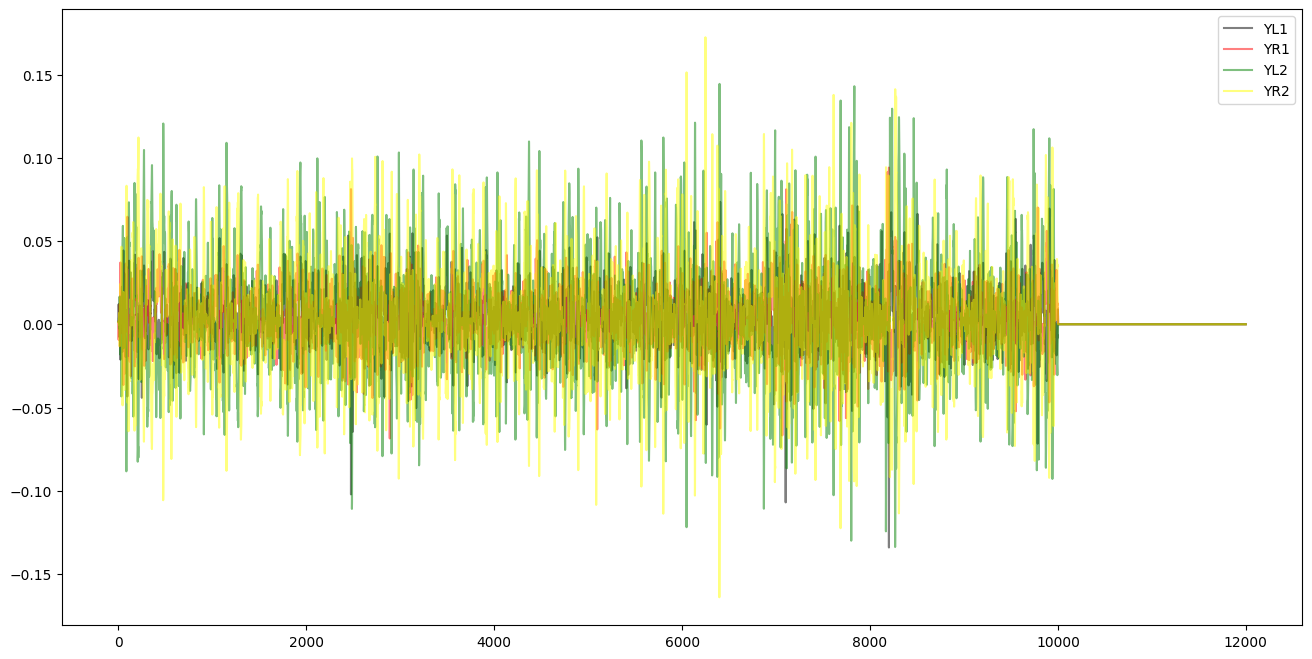

In [ ]:
train50 = pd.merge(left=s50, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X50 = train50.drop(target, axis=1)
y50 = train50.loc[:, target]

plt.figure(figsize=(16,8))

plt.plot(y50.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y50.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y50.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y50.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

## 2-5. S40 탈선 계수 그래프

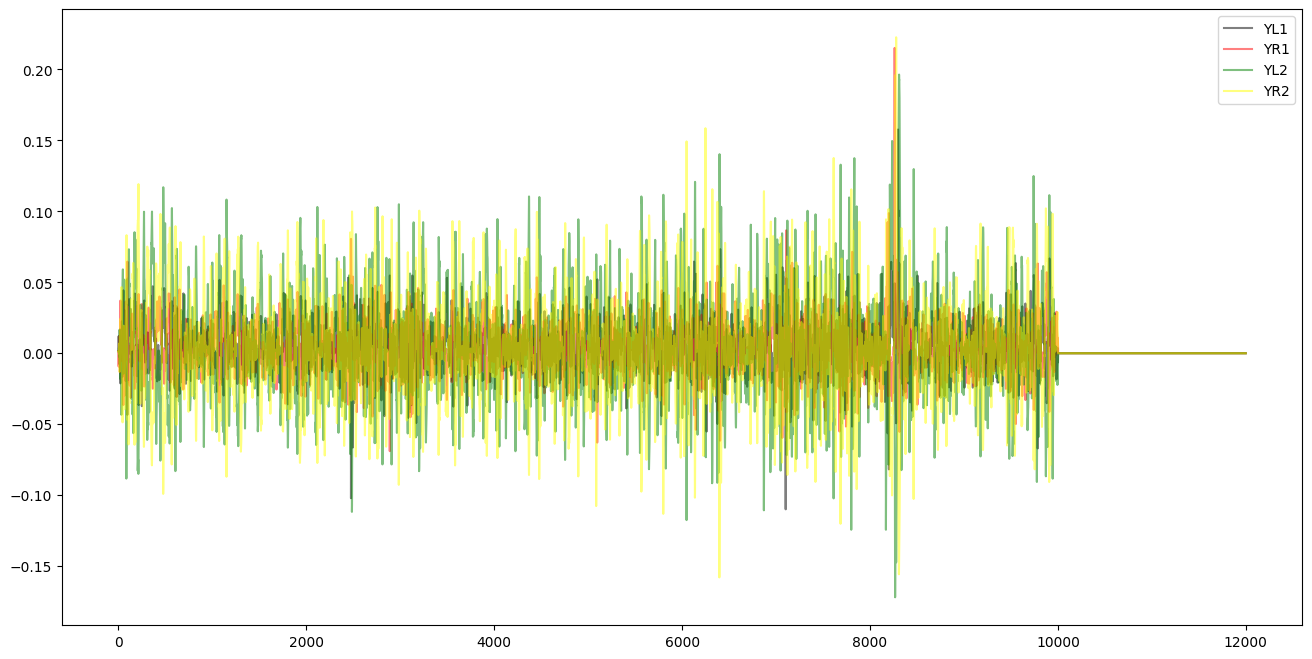

In [ ]:
train40 = pd.merge(left=s40, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X40 = train40.drop(target, axis=1)
y40 = train40.loc[:, target]

plt.figure(figsize=(16,8))

plt.plot(y40.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y40.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y40.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y40.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

## 2-6. S30 탈선 계수 그래프

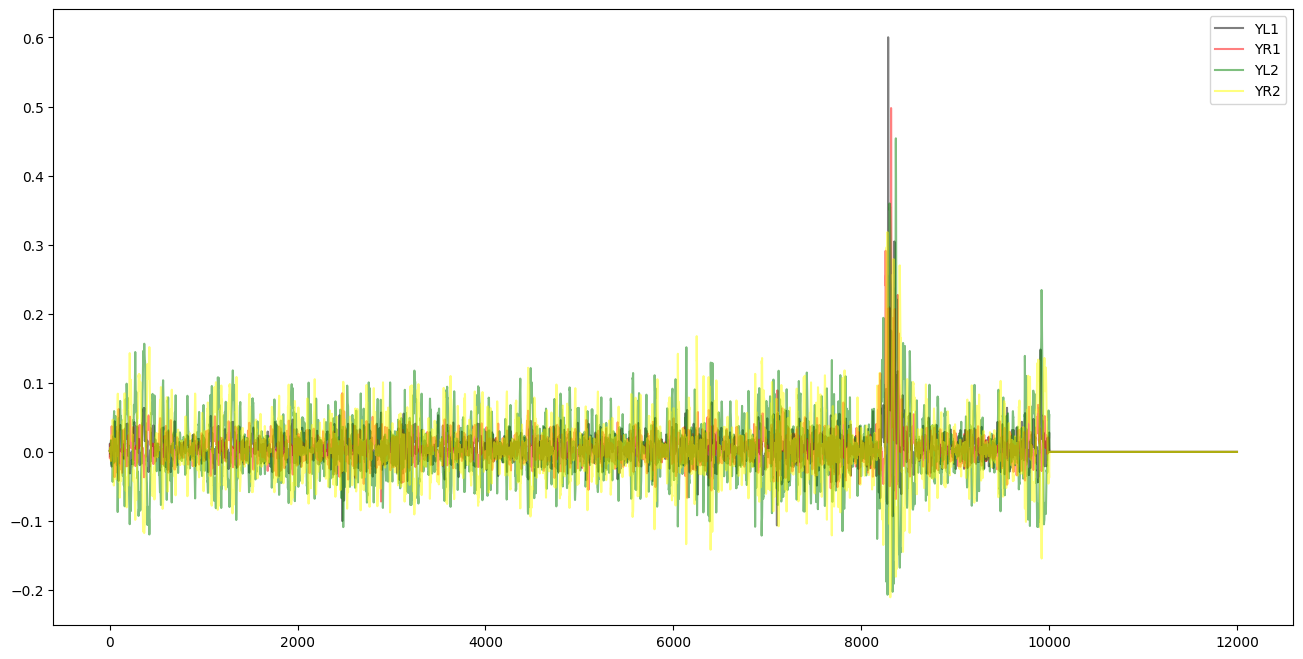

In [ ]:
train30 = pd.merge(left=s30, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X30 = train30.drop(target, axis=1)
y30 = train30.loc[:, target]

plt.figure(figsize=(16,8))

plt.plot(y30.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y30.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y30.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y30.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

## 2-7. 칼럼 추가

In [ ]:
train100['damper'] = '100'
train70['damper'] = '70'
train50['damper'] = '50'
train40['damper'] = '40'
train30['damper'] = '30'

In [ ]:
def calc_accel(df): # 총 가속도
    df["A_M1_C_B1_accel"] = df["A_M1_C_B1_Y"] + df["A_M1_C_B1_Z"] # 대차상부
    df["A_M1_B1_W1_accel_L"] = df["A_M1_B1_W1_Y_L"] + df["A_M1_B1_W1_Z_L"] # 좌측 전위 대차 프레임
    df["A_M1_B1_BC_accel_L"] = df["A_M1_B1_BC_Y_L"] + df["A_M1_B1_BC_Z_L"] # 좌측 중앙 대차 프레임
    df["A_M1_B1_W2_accel_L"] = df["A_M1_B1_W2_Y_L"] + df["A_M1_B1_W2_Z_L"] # 좌측 후위 대차 프레임
    df["A_M1_B1_W1_accel_R"] = df["A_M1_B1_W1_Y_R"] + df["A_M1_B1_W1_Z_R"] # 우측 전위 대차 프레임
    df["A_M1_B1_BC_accel_R"] = df["A_M1_B1_BC_Y_R"] + df["A_M1_B1_BC_Z_R"] # 우측 중앙 대차 프레임
    df["A_M1_B1_W2_accel_R"] = df["A_M1_B1_W2_Y_R"] + df["A_M1_B1_W2_Z_R"] # 우측 후위 대차 프레임

    df["A__B1_W1_accel_A_axle_L"] = df["A__B1_W1_Y_A_axle_L"] + df["A__B1_W1_Z_A_axle_L"] # 좌측 전위 액슬박스
    df["A__B1_W2_accel_A_axle_L"] = df["A__B1_W2_Y_A_axle_L"] + df["A__B1_W2_Z_A_axle_L"] # 좌측 후위 액슬박스
    df["A__B1_W1_accel_A_axle_R"] = df["A__B1_W1_Y_A_axle_R"] + df["A__B1_W1_Z_A_axle_R"] # 우측 전위 액슬박스
    df["A__B1_W2_accel_A_axle_R"] = df["A__B1_W2_Y_A_axle_R"] + df["A__B1_W2_Z_A_axle_R"] # 우측 후위 액슬박스

calc_accel(train30)
calc_accel(train40)
calc_accel(train50)
calc_accel(train70)
calc_accel(train100)

In [ ]:
def calc_left_right_diff(df):
  # 좌우 프레임의 가속도 차이를 활용하여 차량의 균형과 조향 특성을 분석할 수 있습니다.
  # 프레임 가속도 차이 = 좌측 프레임 가속도 - 우측 프레임 가속도
  #  'A_M1_B1_W1_Y_L': '좌측 전위 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_BC_Y_L': '좌측 중앙 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_W2_Y_L': '좌측 후위 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_W1_Y_R': '우측 전위 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_BC_Y_R': '우측 중앙 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_W2_Y_R': '우측 후위 대차 프레임 횡가속도[m/s^2]',
  df['A_M1_B1_Y_diff'] = ((df['A_M1_B1_W1_Y_L'] + df['A_M1_B1_BC_Y_L'] + df['A_M1_B1_W2_Y_L']) -
                          (df['A_M1_B1_W1_Y_R'] + df['A_M1_B1_BC_Y_R'] + df['A_M1_B1_W2_Y_R'])) # 횡가속도 차이

calc_left_right_diff(train30)
calc_left_right_diff(train40)
calc_left_right_diff(train50)
calc_left_right_diff(train70)
calc_left_right_diff(train100)


In [ ]:
def calc_weight_vertical(df):
  # 차륜 하중과 프레임 수직 가속도 관계 = 프레임 수직 가속도 / 해당 프레임 위치의 차륜 수직하중
  # 프레임 수직 가속도: 좌측 전위 대차 프레임 수직 가속도 + 좌측 중앙 대차 프레임 수직 가속도 + 좌측 후위 대차 프레임 수직 가속도 (또는 우측 프레임의 경우)
  # 해당 프레임 위치의 차륜 수직하중: 좌측 전위 차륜 수직하중 + 좌측 중앙 차륜 수직하중 + 좌측 후위 차륜 수직하중 (또는 우측 프레임의 경우)

  #  'A_M1_B1_W1_Z_L': '좌측 전위 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_BC_Z_L': '좌측 중앙 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_W2_Z_L': '좌측 후위 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_W1_Z_R': '우측 전위 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_BC_Z_R': '우측 중앙 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_W2_Z_R': '우측 후위 대차 프레임 수직가속도[m/s^2]',
  #  'V_M1_B1_W1_L': '좌측 전위 차륜 수직하중[kN]',
  #  'V_M1_B1_W1_R': '우측 전위 차륜 수직하중[kN]',
  #  'V_M1_B1_W2_L': '좌측 후위 차륜 수직하중[kN]',
  #  'V_M1_B1_W2_R': '우측 후위 차륜 수직하중[kN]',

  df['weight_vertical_W1_L'] = df['A_M1_B1_W1_Z_L'] / df['V_M1_B1_W1_L']
  df['weight_vertical_W2_L'] = df['A_M1_B1_W2_Z_L'] / df['V_M1_B1_W2_L']
  df['weight_vertical_W1_R'] = df['A_M1_B1_W1_Z_R'] / df['V_M1_B1_W1_R']
  df['weight_vertical_W2_R'] = df['A_M1_B1_W2_Z_R'] / df['V_M1_B1_W2_R']

calc_weight_vertical(train30)
calc_weight_vertical(train40)
calc_weight_vertical(train50)
calc_weight_vertical(train70)
calc_weight_vertical(train100)

In [ ]:
# 좌측, 우측 엑슬박스 횡가속도 차이
def calc_axle_accel_diff(df):
    df["axle_front_accel_diff"] = df['A__B1_W1_Y_A_axle_L']- df['A__B1_W1_Y_A_axle_R']
    df["axle_back_accel_diff"] = df['A__B1_W2_Y_A_axle_L']- df['A__B1_W2_Y_A_axle_R']

calc_axle_accel_diff(train30)
calc_axle_accel_diff(train40)
calc_axle_accel_diff(train50)
calc_axle_accel_diff(train70)
calc_axle_accel_diff(train100)

In [ ]:
trains = [train100, train70, train50, train40, train30]

straight = pd.DataFrame()

for train in trains:
  straight = pd.concat([straight, train], axis=0)

straight

,Distance,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,...,A__B1_W2_accel_A_axle_L,A__B1_W1_accel_A_axle_R,A__B1_W2_accel_A_axle_R,A_M1_B1_Y_diff,weight_vertical_W1_L,weight_vertical_W2_L,weight_vertical_W1_R,weight_vertical_W2_R,axle_front_accel_diff,axle_back_accel_diff
0,0.00,-1.273400e-09,-1.943500e-08,0.022194,0.022194,0.022194,0.022194,0.022194,0.022194,-0.055737,...,0.086081,33.440532,-0.086130,0.000000,0.002738,-67.010111,0.002308,65.812682,0.000000,0.000000
1,0.25,1.485600e-05,3.403000e-06,0.161500,0.159800,0.158200,0.161500,0.159800,0.158200,-0.369500,...,0.038291,7.367400,-0.044163,0.000000,0.064406,36.712001,0.070409,30.350404,0.000600,0.000000
2,0.50,2.706500e-04,5.112900e-05,0.579500,0.569500,0.559500,0.579500,0.569500,0.559500,-1.329000,...,-0.213270,3.462800,0.217630,0.000000,0.233363,165.981981,0.259397,137.419674,0.002200,0.000000
3,0.75,1.247900e-03,1.295900e-04,0.812000,0.789500,0.767100,0.811800,0.789300,0.766900,-2.511000,...,-0.664204,-19.327100,0.734990,0.000600,0.151265,-11.856678,-0.098592,-12.677063,-0.000200,0.000006
4,1.00,3.080900e-03,-1.466900e-03,0.383100,0.349700,0.316300,0.382700,0.349300,0.315900,-5.545000,...,-0.824940,-19.225914,0.971714,0.001200,0.287902,-0.379201,0.226546,-1.849619,-0.001394,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2998.75,9.026600e-02,8.505400e-02,-1.096000,-1.012000,-0.927300,-1.098000,-1.014000,-0.929000,10.430000,...,-11.144000,4.524000,-5.273000,0.005700,0.735543,-0.088132,-0.114045,0.581473,0.002100,0.008000
11996,2999.00,1.043000e-01,9.336100e-02,-0.938800,0.048887,1.037000,-0.939500,0.048170,1.036000,5.924000,...,1.410700,0.646200,-12.171000,0.002417,0.577388,0.953651,0.029994,0.589755,0.005800,0.005900
11997,2999.25,1.151000e-01,7.851500e-02,-0.405400,1.249000,2.902000,-0.404900,1.249000,2.903000,0.466600,...,5.843500,9.879500,-27.139300,-0.001500,0.070955,1.144847,0.089152,0.391447,0.002500,-0.008200
11998,2999.50,1.239000e-01,4.084100e-02,-0.312900,1.486000,3.285000,-0.311900,1.487000,3.286000,-0.784600,...,-4.755000,10.261550,-34.259000,-0.003000,-10.832528,0.682627,0.130821,0.259008,-0.002895,-0.011000


In [ ]:
straight.head()

,Distance,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,...,A__B1_W2_accel_A_axle_L,A__B1_W1_accel_A_axle_R,A__B1_W2_accel_A_axle_R,A_M1_B1_Y_diff,weight_vertical_W1_L,weight_vertical_W2_L,weight_vertical_W1_R,weight_vertical_W2_R,axle_front_accel_diff,axle_back_accel_diff
0,0.00,-1.273400e-09,-1.943500e-08,0.022194,0.022194,0.022194,0.022194,0.022194,0.022194,-0.055737,...,0.086081,33.440532,-0.086130,0.0000,0.002738,-67.010111,0.002308,65.812682,0.000000,0.000000
1,0.25,1.485600e-05,3.403000e-06,0.161500,0.159800,0.158200,0.161500,0.159800,0.158200,-0.369500,...,0.038291,7.367400,-0.044163,0.0000,0.064406,36.712001,0.070409,30.350404,0.000600,0.000000
2,0.50,2.706500e-04,5.112900e-05,0.579500,0.569500,0.559500,0.579500,0.569500,0.559500,-1.329000,...,-0.213270,3.462800,0.217630,0.0000,0.233363,165.981981,0.259397,137.419674,0.002200,0.000000
3,0.75,1.247900e-03,1.295900e-04,0.812000,0.789500,0.767100,0.811800,0.789300,0.766900,-2.511000,...,-0.664204,-19.327100,0.734990,0.0006,0.151265,-11.856678,-0.098592,-12.677063,-0.000200,0.000006
4,1.00,3.080900e-03,-1.466900e-03,0.383100,0.349700,0.316300,0.382700,0.349300,0.315900,-5.545000,...,-0.824940,-19.225914,0.971714,0.0012,0.287902,-0.379201,0.226546,-1.849619,-0.001394,0.000046


In [ ]:
straight = pd.get_dummies(straight, columns=['damper'], drop_first=True)

In [ ]:
straight

,Distance,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,...,weight_vertical_W1_L,weight_vertical_W2_L,weight_vertical_W1_R,weight_vertical_W2_R,axle_front_accel_diff,axle_back_accel_diff,damper_30,damper_40,damper_50,damper_70
0,0.00,-1.273400e-09,-1.943500e-08,0.022194,0.022194,0.022194,0.022194,0.022194,0.022194,-0.055737,...,0.002738,-67.010111,0.002308,65.812682,0.000000,0.000000,0,0,0,0
1,0.25,1.485600e-05,3.403000e-06,0.161500,0.159800,0.158200,0.161500,0.159800,0.158200,-0.369500,...,0.064406,36.712001,0.070409,30.350404,0.000600,0.000000,0,0,0,0
2,0.50,2.706500e-04,5.112900e-05,0.579500,0.569500,0.559500,0.579500,0.569500,0.559500,-1.329000,...,0.233363,165.981981,0.259397,137.419674,0.002200,0.000000,0,0,0,0
3,0.75,1.247900e-03,1.295900e-04,0.812000,0.789500,0.767100,0.811800,0.789300,0.766900,-2.511000,...,0.151265,-11.856678,-0.098592,-12.677063,-0.000200,0.000006,0,0,0,0
4,1.00,3.080900e-03,-1.466900e-03,0.383100,0.349700,0.316300,0.382700,0.349300,0.315900,-5.545000,...,0.287902,-0.379201,0.226546,-1.849619,-0.001394,0.000046,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2998.75,9.026600e-02,8.505400e-02,-1.096000,-1.012000,-0.927300,-1.098000,-1.014000,-0.929000,10.430000,...,0.735543,-0.088132,-0.114045,0.581473,0.002100,0.008000,1,0,0,0
11996,2999.00,1.043000e-01,9.336100e-02,-0.938800,0.048887,1.037000,-0.939500,0.048170,1.036000,5.924000,...,0.577388,0.953651,0.029994,0.589755,0.005800,0.005900,1,0,0,0
11997,2999.25,1.151000e-01,7.851500e-02,-0.405400,1.249000,2.902000,-0.404900,1.249000,2.903000,0.466600,...,0.070955,1.144847,0.089152,0.391447,0.002500,-0.008200,1,0,0,0
11998,2999.50,1.239000e-01,4.084100e-02,-0.312900,1.486000,3.285000,-0.311900,1.487000,3.286000,-0.784600,...,-10.832528,0.682627,0.130821,0.259008,-0.002895,-0.011000,1,0,0,0


## 2-8. 데이터 분리

In [ ]:
data = straight.drop(['Distance'], axis=1)

In [ ]:
split_data = []

for idx in range(0, 60000, 12000):
  split_data.append(data.iloc[idx:idx+12000])

In [ ]:
train_data = []
test_data = []

meter = 7
k = int(meter // 0.25)

for sd in split_data:

  train_data.append(sd.iloc[:-2000, :])
  test_data.append(sd.iloc[-(2000+k):, ])

train_data

[       A_M1_C_B1_Y   A_M1_C_B1_Z  A_M1_B1_W1_Y_L  A_M1_B1_BC_Y_L  \
 0    -1.273400e-09 -1.943500e-08        0.022194        0.022194   
 1     1.485600e-05  3.403000e-06        0.161500        0.159800   
 2     2.706500e-04  5.112900e-05        0.579500        0.569500   
 3     1.247900e-03  1.295900e-04        0.812000        0.789500   
 4     3.080900e-03 -1.466900e-03        0.383100        0.349700   
 ...            ...           ...             ...             ...   
 9995 -1.849000e-01  1.065900e-03       -2.284000       -2.132000   
 9996 -2.017000e-01  3.841500e-02       -2.531000       -1.829000   
 9997 -2.222000e-01  5.682700e-02       -1.879000       -0.970000   
 9998 -2.451000e-01  4.983000e-02       -0.921500       -0.448200   
 9999 -2.681000e-01  1.697700e-02       -0.233400       -0.538600   
 
       A_M1_B1_W2_Y_L  A_M1_B1_W1_Y_R  A_M1_B1_BC_Y_R  A_M1_B1_W2_Y_R  \
 0           0.022194        0.022194        0.022194        0.022194   
 1           0.158200   

In [ ]:
test_data[1]

,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,A_M1_B1_BC_Z_L,...,weight_vertical_W1_L,weight_vertical_W2_L,weight_vertical_W1_R,weight_vertical_W2_R,axle_front_accel_diff,axle_back_accel_diff,damper_30,damper_40,damper_50,damper_70
9972,0.271600,0.066623,-1.1780,-1.2150,-1.2520,-1.1800,-1.2170,-1.2540,-6.6970,-1.3060,...,-31.309023,-0.460178,0.233180,0.480521,-0.006600,0.014000,0,0,0,1
9973,0.265000,0.073174,-1.7930,-1.1410,-0.4900,-1.7950,-1.1440,-0.4928,-5.4610,0.5419,...,1.494118,-1.879667,0.162509,1.333079,0.001900,0.025000,0,0,0,1
9974,0.252800,0.095284,-2.3720,-1.4800,-0.5873,-2.3740,-1.4820,-0.5896,-2.8470,0.9147,...,0.645725,1.087927,0.324962,-4.546512,0.006200,0.015000,0,0,0,1
9975,0.233200,0.121200,-3.0570,-2.1230,-1.1890,-3.0570,-2.1230,-1.1890,0.1214,0.3435,...,-0.018910,0.065607,10.714286,0.808542,0.007000,0.011200,0,0,0,1
9976,0.205300,0.135500,-3.2310,-2.1940,-1.1570,-3.2290,-2.1920,-1.1550,0.9666,-0.8072,...,-0.156967,-0.273788,-1.061416,1.421847,0.005000,0.015266,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.055239,0.087084,-1.0450,-1.3120,-1.5790,-1.0460,-1.3130,-1.5800,10.5600,5.7260,...,0.746818,-0.102815,-0.121378,0.571816,0.000700,0.008000,0,0,0,1
11996,0.066026,0.095299,-0.9352,-0.1846,0.5659,-0.9358,-0.1853,0.5653,6.1000,-0.7349,...,0.598039,1.001720,0.011498,0.584979,0.004100,0.005400,0,0,0,1
11997,0.073787,0.080321,-0.7124,1.1250,2.9630,-0.7120,1.1260,2.9630,0.6098,-5.8260,...,0.092647,1.178846,0.085250,0.389484,0.002496,-0.009200,0,0,0,1
11998,0.079801,0.042560,-0.9097,1.4760,3.8620,-0.9086,1.4770,3.8630,-0.7068,-5.8840,...,-7.244030,0.689956,0.127767,0.258775,-0.002100,-0.011000,0,0,0,1


## 2-9. 스케일러 적용

In [ ]:
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame()
df_test = pd.DataFrame()

for td in train_data:

  df = pd.concat([df, td], axis=0)

for te in test_data:

  df_test = pd.concat([df_test, te], axis=0)

df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

sc_df = df.drop(target+['damper_30','damper_40','damper_50','damper_70'], axis=1)
non_df = df.loc[:, target+['damper_30','damper_40','damper_50','damper_70']]

sc_df_test = df_test.drop(target+['damper_30','damper_40','damper_50','damper_70'], axis=1)
non_df_test = df_test.loc[:, target+['damper_30','damper_40','damper_50','damper_70']]

# StandardScaler 객체 생성
scaler = StandardScaler()

# StandardScaler를 DataFrame에 적용
scaled_df = pd.DataFrame(scaler.fit_transform(sc_df), columns=sc_df.columns)
scaled_df_test = pd.DataFrame(scaler.transform(sc_df_test), columns=sc_df_test.columns)

scaled_df = pd.concat([scaled_df, non_df], axis=1)
scaled_df_test = pd.concat([scaled_df_test, non_df_test], axis=1)

split_data = []
split_data_test = []

for idx in range(0, 50000, 10000):
  split_data.append(scaled_df.iloc[idx:idx+10000])

for idx in range(0, (10000+5*k), (2000+k)):
  split_data_test.append(scaled_df_test.iloc[idx:idx+(2000+k)])

split_data[4]

,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,A_M1_B1_BC_Z_L,...,axle_front_accel_diff,axle_back_accel_diff,YL_M1_B1_W1,YR_M1_B1_W1,YL_M1_B1_W2,YR_M1_B1_W2,damper_30,damper_40,damper_50,damper_70
40000,-0.002098,-0.000244,0.011965,0.016293,0.009413,0.011964,0.016298,0.009413,-0.008297,-0.011733,...,-0.000192,0.002438,0.001366,0.001558,0.001412,0.001406,1,0,0,0
40001,-0.002025,-0.000227,0.086984,0.114142,0.063632,0.086992,0.114173,0.063638,-0.056782,-0.082705,...,0.051706,0.002438,0.007337,-0.004638,0.001448,0.001525,1,0,0,0
40002,-0.000763,0.000004,0.312085,0.405471,0.223613,0.312119,0.405581,0.223636,-0.205048,-0.294585,...,0.190099,0.002438,0.011998,-0.009334,0.001715,0.001607,1,0,0,0
40003,0.004058,0.000385,0.437290,0.561909,0.306375,0.437232,0.561919,0.306326,-0.387697,-0.467284,...,-0.017491,0.002918,0.008566,-0.005116,0.002410,0.001200,1,0,0,0
40004,0.013101,-0.007363,0.206320,0.249176,0.126660,0.206126,0.248959,0.126513,-0.856525,-0.624008,...,-0.120767,0.006119,0.002605,0.001091,0.003430,0.000351,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-1.257600,0.014780,0.682855,0.361953,-0.099498,0.684550,0.364683,-0.098074,-0.024038,0.400745,...,1.020459,-0.557759,0.012157,0.008648,0.045937,-0.030542,1,0,0,0
49996,-1.151043,0.196797,0.752324,0.515831,0.021604,0.752950,0.517251,0.022314,-0.515025,-0.289404,...,1.037758,0.002438,0.020113,0.000494,0.044889,-0.028493,1,0,0,0
49997,-1.052872,0.287722,1.067357,1.016645,0.349828,1.065867,1.014786,0.348867,-1.003015,-1.124619,...,-0.865150,0.082466,0.022017,-0.000850,0.045732,-0.028144,1,0,0,0
49998,-0.957661,0.256084,1.252607,1.238502,0.461412,1.250601,1.235992,0.459865,-1.228312,-1.540177,...,-0.778654,0.002438,0.019196,0.003216,0.046418,-0.029297,1,0,0,0


In [ ]:
X = []
y = []

X_valiation = []
y_valiation = []

for sd in split_data:
  sd_x = sd
  sd_y = sd.loc[:,target]

  k = int(meter // 0.25)

  for j in range(k, len(sd)): # 25m 당
      if j < 9500:
        X.append(sd_x.iloc[j-k:j, :].values)
        y.append(sd_y.iloc[j, :].values)
      else:
        X_valiation.append(sd_x.iloc[j-k:j, :].values)
        y_valiation.append(sd_y.iloc[j, :].values)

In [ ]:
X_train= np.array(X)
Y_train= np.array(y)
X_val= np.array(X_valiation)
Y_val= np.array(y_valiation)

In [ ]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((47360, 28, 61), (47360, 4), (2500, 28, 61), (2500, 4))

## 2-10. 직선 모델링

In [ ]:
from tensorflow import keras

keras.backend.clear_session()

il = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

conv1 = keras.layers.Conv1D(filters=64, kernel_size=16, padding='same')(il)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='selu')(conv1)

conv2 = keras.layers.Conv1D(filters=128, kernel_size=32, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('selu')(conv2)

conv3 = keras.layers.Conv1D(filters=256, kernel_size=64, padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('selu')(conv3)

h2 = keras.layers.AveragePooling1D()(conv3)

lstm = keras.layers.LSTM(12)(h2)
hl = keras.layers.Flatten()(lstm)
hl = keras.layers.Dense(100)(hl)

ol = keras.layers.Dense(4)(hl)

model = keras.models.Model(inputs=il, outputs=ol)

model.compile(loss=keras.losses.mae, optimizer = keras.optimizers.Nadam())

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 61)]          0         
                                                                 
 conv1d (Conv1D)             (None, 28, 64)            62528     
                                                                 
 batch_normalization (BatchN  (None, 28, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 128)           262272    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 128)          512       
 hNormalization)                                             

## 2-11. 직선 모델 학습

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      verbose=1,
                                      restore_best_weights=True,
                                      patience=7)

mc = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                        filepath=f'/content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam.h5',
                        save_best_only=True,
                        verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-6)

In [ ]:
hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=[es, mc, reduce_lr], verbose=1, epochs=100)

Epoch 1/100
1477/1480 [============================>.] - ETA: 0s - loss: 0.0091
Epoch 1: val_loss improved from inf to 0.00556, saving model to /content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam.h5
1480/1480 [==============================] - 22s 10ms/step - loss: 0.0091 - val_loss: 0.0056 - lr: 0.0010
Epoch 2/100
1478/1480 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 2: val_loss improved from 0.00556 to 0.00537, saving model to /content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam.h5
1480/1480 [==============================] - 15s 10ms/step - loss: 0.0049 - val_loss: 0.0054 - lr: 0.0010
Epoch 3/100
1477/1480 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 3: val_loss improved from 0.00537 to 0.00418, saving model to /content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam.h5
1480/1480 [=======

## 2-12. 학습 결과 시각화

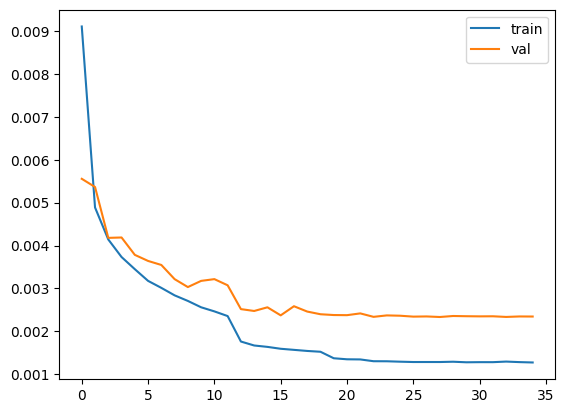

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()

# 3. 곡선 구간 학습

## 3-1. 데이터 불러오기

In [ ]:
# c 커브 구간

damper = ['30', '40', '50', '70', '100']

c100 = pd.read_csv("./data_c100.csv")
c70 = pd.read_csv("./data_c70.csv")
c50 = pd.read_csv("./data_c50.csv")
c40 = pd.read_csv("./data_c40.csv")
c30 = pd.read_csv("./data_c30.csv")


In [ ]:
# 선로 데이터
lane = pd.read_csv('./lane_data_c.csv')

In [ ]:
lane

,Distance,Curvature,Vertical offset,Cross level offset
0,0.00,0.0,0.0,0.0
1,0.25,0.0,0.0,0.0
2,0.50,0.0,0.0,0.0
3,0.75,0.0,0.0,0.0
4,1.00,0.0,0.0,0.0
...,...,...,...,...
11995,2998.75,0.0,0.0,0.0
11996,2999.00,0.0,0.0,0.0
11997,2999.25,0.0,0.0,0.0
11998,2999.50,0.0,0.0,0.0


In [ ]:
c_col = pd.read_csv('./lane_data_columns.csv', encoding='CP949')

In [ ]:
c_col

,type,name,description
0,curve,Distance,거리[m]
1,curve,Curvature,곡률[1/km]
2,curve,Vertical offset,선로중심부 높이[mm]
3,curve,Cross level offset,캔트[mm]
4,straight,Distance,거리[m]
5,straight,Cross level irregularity,우측 선로에 대한 좌측 선로 높이차(캔트) 불규칙도[mm]
6,straight,Curvature irregularity,곡선에 대한 불규칙도[1/km]
7,straight,Lateral irregularity,수평 불규칙도[mm]
8,straight,Vertical irregularity,수직 불규칙도[mm]
9,straight,Gauge variation,선로 게이지(좌우거리차이) 불규칙도[mm]


In [ ]:
c_columns = dict()

for col in c_col.values:
  t, n, d = col
  if t == 'curve':
    c_columns[n] = d

c_columns

{'Distance': '거리[m]',
 'Curvature': '곡률[1/km]',
 'Vertical offset': '선로중심부 높이[mm]',
 'Cross level offset': '캔트[mm]'}

In [ ]:
train_col = pd.read_csv('./data_columns.csv')

In [ ]:
train_col

,name,description
0,Distance,거리[m]
1,A_M1_C_B1_Y,대차상부 차체 횡가속도[m/s^2]
2,A_M1_C_B1_Z,대차상부 차체 수직가속도[m/s^2]
3,A_M1_B1_W1_Y_L,좌측 전위 대차 프레임 횡가속도[m/s^2]
4,A_M1_B1_BC_Y_L,좌측 중앙 대차 프레임 횡가속도[m/s^2]
5,A_M1_B1_W2_Y_L,좌측 후위 대차 프레임 횡가속도[m/s^2]
6,A_M1_B1_W1_Y_R,우측 전위 대차 프레임 횡가속도[m/s^2]
7,A_M1_B1_BC_Y_R,우측 중앙 대차 프레임 횡가속도[m/s^2]
8,A_M1_B1_W2_Y_R,우측 후위 대차 프레임 횡가속도[m/s^2]
9,A_M1_B1_W1_Z_L,좌측 전위 대차 프레임 수직가속도[m/s^2]


In [ ]:
columns = dict()

for name, des in zip(train_col['name'].values, train_col['description'].values):
  columns[name] = des

columns

{'Distance': '거리[m]',
 'A_M1_C_B1_Y': '대차상부 차체 횡가속도[m/s^2]',
 'A_M1_C_B1_Z': '대차상부 차체 수직가속도[m/s^2]',
 'A_M1_B1_W1_Y_L': '좌측 전위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_BC_Y_L': '좌측 중앙 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W2_Y_L': '좌측 후위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W1_Y_R': '우측 전위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_BC_Y_R': '우측 중앙 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W2_Y_R': '우측 후위 대차 프레임 횡가속도[m/s^2]',
 'A_M1_B1_W1_Z_L': '좌측 전위 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_BC_Z_L': '좌측 중앙 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_W2_Z_L': '좌측 후위 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_W1_Z_R': '우측 전위 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_BC_Z_R': '우측 중앙 대차 프레임 수직가속도[m/s^2]',
 'A_M1_B1_W2_Z_R': '우측 후위 대차 프레임 수직가속도[m/s^2]',
 'A__B1_W1_Y_A_axle_L': '좌측 전위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W2_Y_A_axle_L': '좌측 후위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W1_Y_A_axle_R': '우측 전위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W2_Y_A_axle_R': '우측 후위 액슬박스 횡가속도[m/s^2]',
 'A__B1_W1_Z_A_axle_L': '좌측 전위 액슬박스 수직가속도[m/s^2]',
 'A__B1_W2_Z_A_axle_L': '좌측 후위 액슬박스 수직가속도[m/s^2]',
 'A__B1_W1_Z_A_axle_R': '우측

## 탈선 계수
$$\frac{Q}{P}\space P:수직방향, Q:수평방향$$
Q가 P보다 커지면 차륜이 레일을 올라타거나 뛰어넘음

## 3-2. C100 탈선 계수 그래프


In [ ]:
train100 = pd.merge(left=c100, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X100 = train100.drop(target, axis=1)
y100 = train100.loc[:, target]

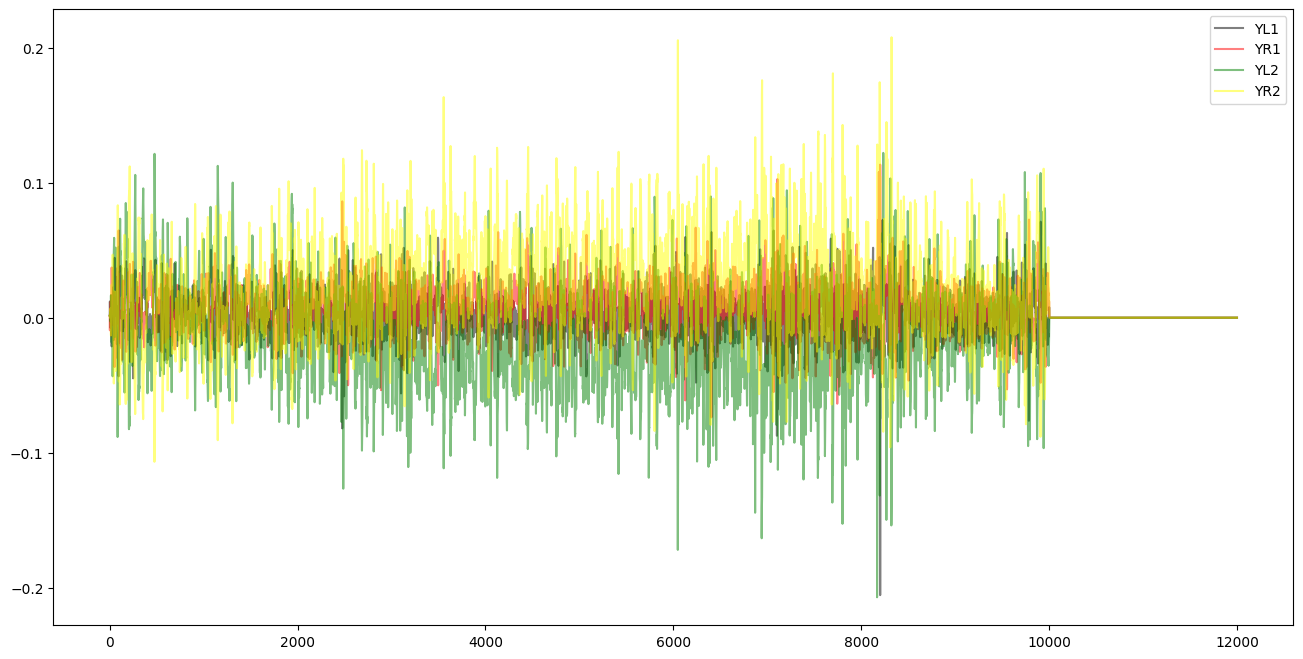

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y100.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y100.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y100.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y100.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

## 3-3. C70 탈선 계수 그래프

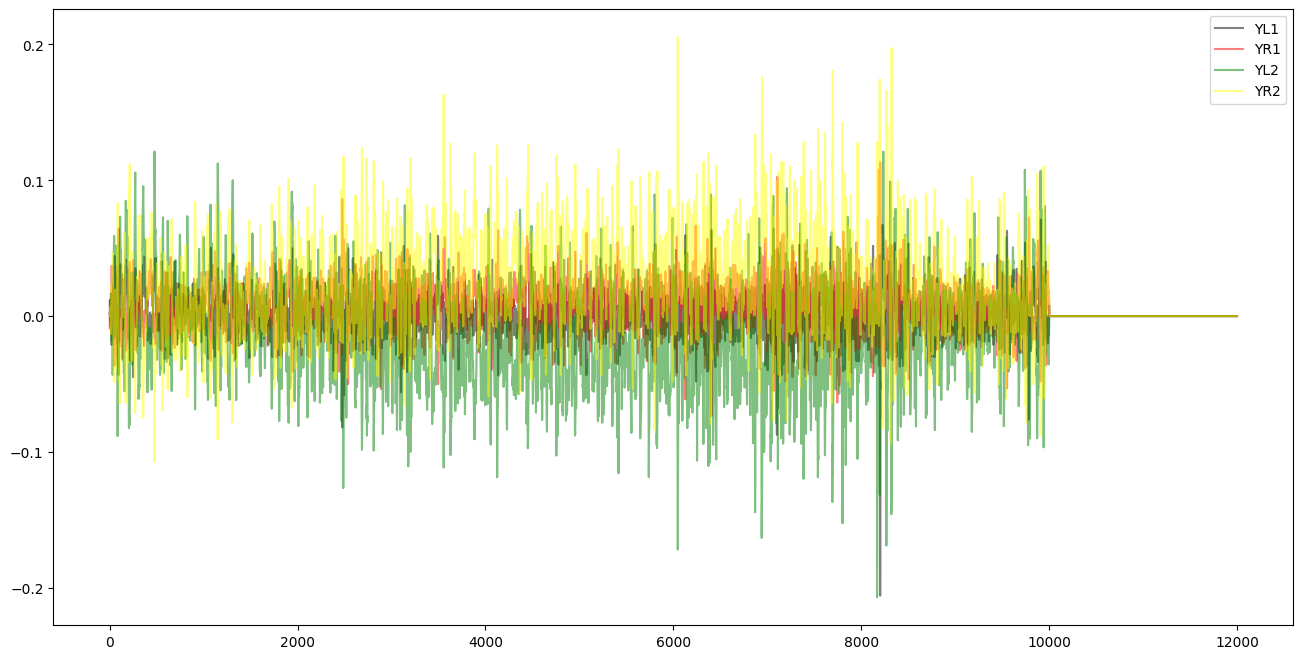

In [ ]:
train70 = pd.merge(left=c70, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X70 = train70.drop(target, axis=1)
y70 = train70.loc[:, target]

plt.figure(figsize=(16,8))
plt.plot(y70.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y70.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y70.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y70.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

In [ ]:
y70.head()

,YL_M1_B1_W1,YR_M1_B1_W1,YL_M1_B1_W2,YR_M1_B1_W2
0,0.001366,0.001558,0.001412,0.001406
1,0.007337,-0.004638,0.001448,0.001525
2,0.011998,-0.009334,0.001715,0.001607
3,0.008566,-0.005116,0.002410,0.001200
4,0.002605,0.001091,0.003430,0.000351


## 3-4. C50 탈선 계수 그래프

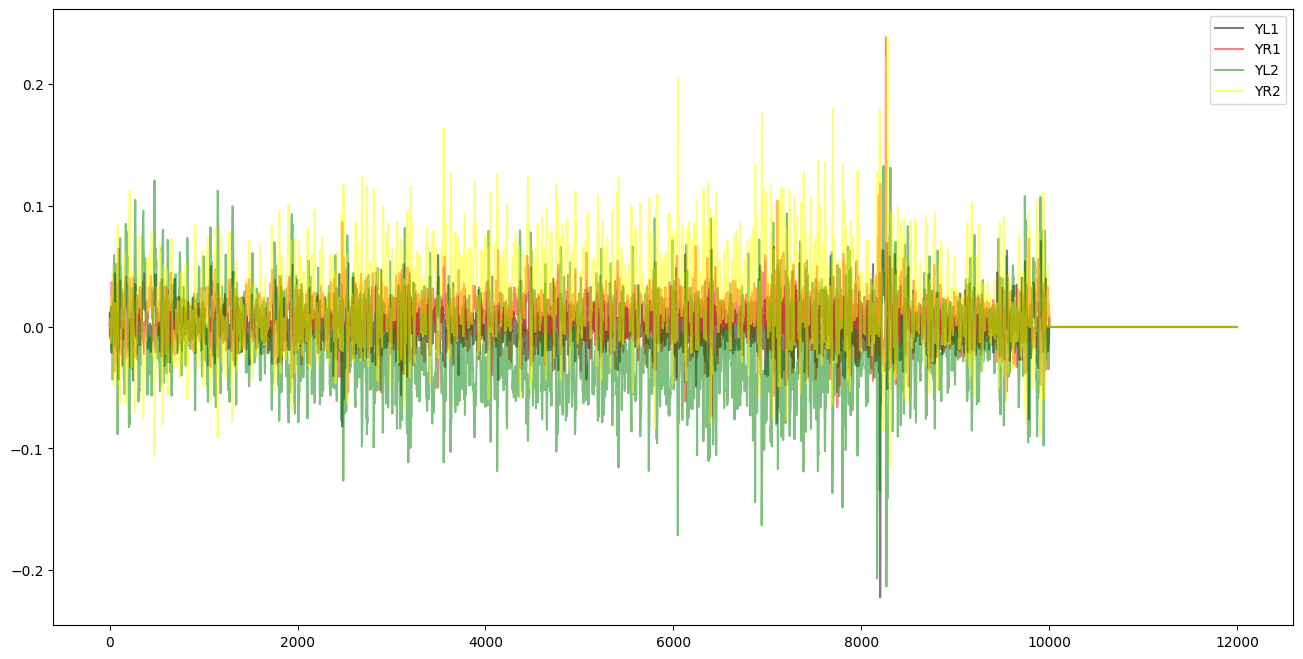

In [ ]:
train50 = pd.merge(left=c50, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X50 = train50.drop(target, axis=1)
y50 = train50.loc[:, target]

plt.figure(figsize=(16,8))
plt.plot(y50.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y50.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y50.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y50.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

In [ ]:
y50.head()

,YL_M1_B1_W1,YR_M1_B1_W1,YL_M1_B1_W2,YR_M1_B1_W2
0,0.001366,0.001558,0.001412,0.001406
1,0.007337,-0.004638,0.001448,0.001525
2,0.011998,-0.009334,0.001715,0.001607
3,0.008566,-0.005116,0.002410,0.001200
4,0.002605,0.001091,0.003430,0.000351


## 3-5. C40 탈선 계수 그래프

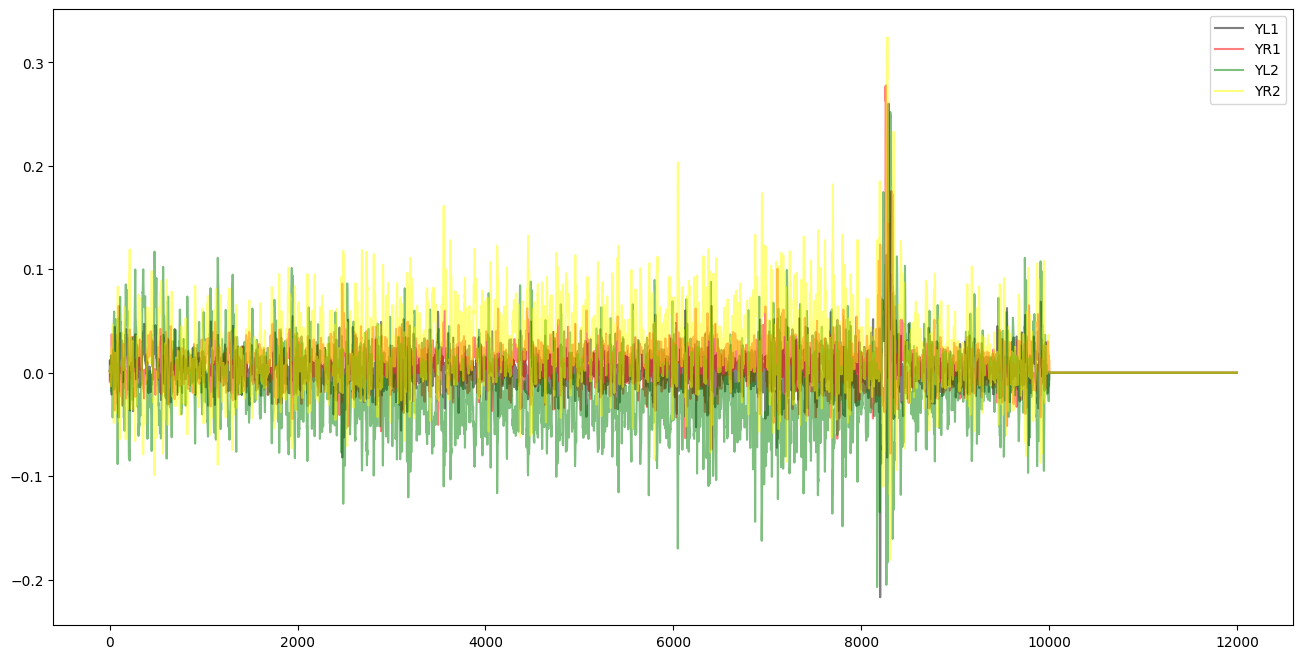

In [ ]:
train40 = pd.merge(left=c40, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X40 = train40.drop(target, axis=1)
y40 = train40.loc[:, target]

plt.figure(figsize=(16,8))
plt.plot(y40.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y40.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y40.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y40.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

In [ ]:
y40.head()

,YL_M1_B1_W1,YR_M1_B1_W1,YL_M1_B1_W2,YR_M1_B1_W2
0,0.001366,0.001558,0.001412,0.001406
1,0.007337,-0.004638,0.001448,0.001525
2,0.011998,-0.009334,0.001715,0.001607
3,0.008566,-0.005116,0.002410,0.001200
4,0.002605,0.001091,0.003430,0.000351


## 3-6. C30 탈선 계수 그래프

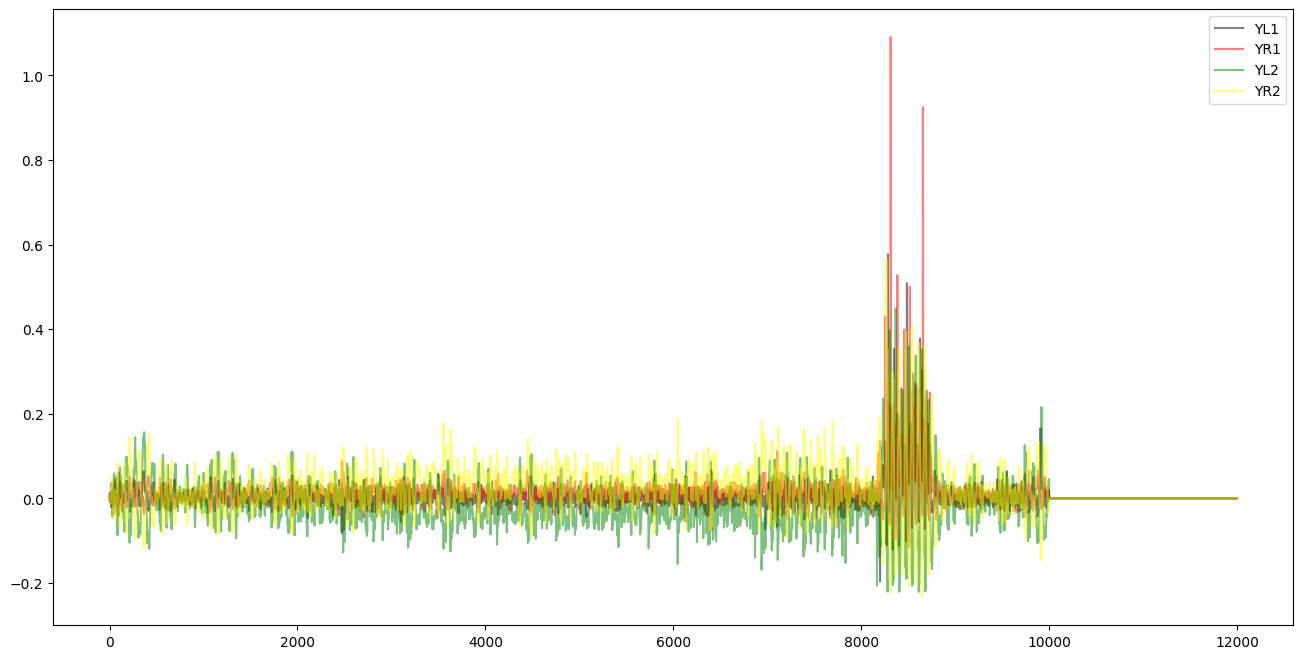

In [ ]:
train30 = pd.merge(left=c30, right=lane, how='inner', on='Distance')

target = ['YL_M1_B1_W1', 'YR_M1_B1_W1', 'YL_M1_B1_W2', 'YR_M1_B1_W2']

X30 = train30.drop(target, axis=1)
y30 = train30.loc[:, target]

plt.figure(figsize=(16,8))

plt.plot(y30.loc[:, 'YL_M1_B1_W1'], color='black', label='YL1', alpha=0.5)
plt.plot(y30.loc[:, 'YR_M1_B1_W1'], color='red', label='YR1', alpha=0.5)
plt.plot(y30.loc[:, 'YL_M1_B1_W2'], color='green', label='YL2', alpha=0.5)
plt.plot(y30.loc[:, 'YR_M1_B1_W2'], color='yellow', label='YR2', alpha=0.5)

plt.legend()
plt.show()

In [ ]:
y30.head()

,YL_M1_B1_W1,YR_M1_B1_W1,YL_M1_B1_W2,YR_M1_B1_W2
0,0.001366,0.001558,0.001412,0.001406
1,0.007337,-0.004638,0.001448,0.001525
2,0.011998,-0.009334,0.001715,0.001607
3,0.008566,-0.005116,0.002410,0.001200
4,0.002605,0.001091,0.003430,0.000351


## 3-7. 칼럼 추가

In [ ]:
train100['damper'] = '100'
train70['damper'] = '70'
train50['damper'] = '50'
train40['damper'] = '40'
train30['damper'] = '30'

In [ ]:
def calc_accel(df): # 총 가속도
    df["A_M1_C_B1_accel"] = df["A_M1_C_B1_Y"] + df["A_M1_C_B1_Z"] # 대차상부
    df["A_M1_B1_W1_accel_L"] = df["A_M1_B1_W1_Y_L"] + df["A_M1_B1_W1_Z_L"] # 좌측 전위 대차 프레임
    df["A_M1_B1_BC_accel_L"] = df["A_M1_B1_BC_Y_L"] + df["A_M1_B1_BC_Z_L"] # 좌측 중앙 대차 프레임
    df["A_M1_B1_W2_accel_L"] = df["A_M1_B1_W2_Y_L"] + df["A_M1_B1_W2_Z_L"] # 좌측 후위 대차 프레임
    df["A_M1_B1_W1_accel_R"] = df["A_M1_B1_W1_Y_R"] + df["A_M1_B1_W1_Z_R"] # 우측 전위 대차 프레임
    df["A_M1_B1_BC_accel_R"] = df["A_M1_B1_BC_Y_R"] + df["A_M1_B1_BC_Z_R"] # 우측 중앙 대차 프레임
    df["A_M1_B1_W2_accel_R"] = df["A_M1_B1_W2_Y_R"] + df["A_M1_B1_W2_Z_R"] # 우측 후위 대차 프레임

    df["A__B1_W1_accel_A_axle_L"] = df["A__B1_W1_Y_A_axle_L"] + df["A__B1_W1_Z_A_axle_L"] # 좌측 전위 액슬박스
    df["A__B1_W2_accel_A_axle_L"] = df["A__B1_W2_Y_A_axle_L"] + df["A__B1_W2_Z_A_axle_L"] # 좌측 후위 액슬박스
    df["A__B1_W1_accel_A_axle_R"] = df["A__B1_W1_Y_A_axle_R"] + df["A__B1_W1_Z_A_axle_R"] # 우측 전위 액슬박스
    df["A__B1_W2_accel_A_axle_R"] = df["A__B1_W2_Y_A_axle_R"] + df["A__B1_W2_Z_A_axle_R"] # 우측 후위 액슬박스

calc_accel(train30)
calc_accel(train40)
calc_accel(train50)
calc_accel(train70)
calc_accel(train100)

In [ ]:
def calc_left_right_diff(df):
  # 좌우 프레임의 가속도 차이를 활용하여 차량의 균형과 조향 특성을 분석할 수 있습니다.
  # 프레임 가속도 차이 = 좌측 프레임 가속도 - 우측 프레임 가속도
  #  'A_M1_B1_W1_Y_L': '좌측 전위 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_BC_Y_L': '좌측 중앙 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_W2_Y_L': '좌측 후위 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_W1_Y_R': '우측 전위 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_BC_Y_R': '우측 중앙 대차 프레임 횡가속도[m/s^2]',
  #  'A_M1_B1_W2_Y_R': '우측 후위 대차 프레임 횡가속도[m/s^2]',
  df['A_M1_B1_Y_diff'] = ((df['A_M1_B1_W1_Y_L'] + df['A_M1_B1_BC_Y_L'] + df['A_M1_B1_W2_Y_L']) -
                          (df['A_M1_B1_W1_Y_R'] + df['A_M1_B1_BC_Y_R'] + df['A_M1_B1_W2_Y_R'])) # 횡가속도 차이

calc_left_right_diff(train30)
calc_left_right_diff(train40)
calc_left_right_diff(train50)
calc_left_right_diff(train70)
calc_left_right_diff(train100)

In [ ]:
def calc_weight_vertical(df):
  # 차륜 하중과 프레임 수직 가속도 관계 = 프레임 수직 가속도 / 해당 프레임 위치의 차륜 수직하중
  # 프레임 수직 가속도: 좌측 전위 대차 프레임 수직 가속도 + 좌측 중앙 대차 프레임 수직 가속도 + 좌측 후위 대차 프레임 수직 가속도 (또는 우측 프레임의 경우)
  # 해당 프레임 위치의 차륜 수직하중: 좌측 전위 차륜 수직하중 + 좌측 중앙 차륜 수직하중 + 좌측 후위 차륜 수직하중 (또는 우측 프레임의 경우)

  #  'A_M1_B1_W1_Z_L': '좌측 전위 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_BC_Z_L': '좌측 중앙 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_W2_Z_L': '좌측 후위 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_W1_Z_R': '우측 전위 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_BC_Z_R': '우측 중앙 대차 프레임 수직가속도[m/s^2]',
  #  'A_M1_B1_W2_Z_R': '우측 후위 대차 프레임 수직가속도[m/s^2]',
  #  'V_M1_B1_W1_L': '좌측 전위 차륜 수직하중[kN]',
  #  'V_M1_B1_W1_R': '우측 전위 차륜 수직하중[kN]',
  #  'V_M1_B1_W2_L': '좌측 후위 차륜 수직하중[kN]',
  #  'V_M1_B1_W2_R': '우측 후위 차륜 수직하중[kN]',

  df['weight_vertical_W1_L'] = df['A_M1_B1_W1_Z_L'] / df['V_M1_B1_W1_L']
  df['weight_vertical_W2_L'] = df['A_M1_B1_W2_Z_L'] / df['V_M1_B1_W2_L']
  df['weight_vertical_W1_R'] = df['A_M1_B1_W1_Z_R'] / df['V_M1_B1_W1_R']
  df['weight_vertical_W2_R'] = df['A_M1_B1_W2_Z_R'] / df['V_M1_B1_W2_R']

calc_weight_vertical(train30)
calc_weight_vertical(train40)
calc_weight_vertical(train50)
calc_weight_vertical(train70)
calc_weight_vertical(train100)

In [ ]:
def calc_vertical_offset_change(df):
  # 선로 중심부의 높이 변화 = 캔트 × 곡률
  # 수식: ΔH = C × k
  # 여기서 ΔH는 선로 중심부의 높이 변화를 나타내며, C는 캔트 값(단위: mm), k는 곡률 값(단위: 1/km)입니다.
  df['Vertical_Offset_Change'] = df['Cross level offset'] * df['Curvature']

calc_vertical_offset_change(train30)
calc_vertical_offset_change(train40)
calc_vertical_offset_change(train50)
calc_vertical_offset_change(train70)
calc_vertical_offset_change(train100)

In [ ]:
def calc_lateral_force(df):
  # 기차의 편향력 = (기차의 질량) × (캔트 × 곡률)^2
  # 수식: F = m × (C × k)^2
  # 여기서 F는 기차의 편향력을 나타내며, m은 기차의 질량, C는 캔트 값(단위: mm), k는 곡률 값(단위: 1/km)입니다.
  df['Lateral Force'] = df['Cross level offset'] * (df['Curvature']**2)

calc_lateral_force(train30)
calc_lateral_force(train40)
calc_lateral_force(train50)
calc_lateral_force(train70)
calc_lateral_force(train100)

In [ ]:
# 좌측, 우측 엑슬박스 횡가속도 차이
def calc_axle_accel_diff(df):
    df["axle_front_accel_diff"] = df['A__B1_W1_Y_A_axle_L']- df['A__B1_W1_Y_A_axle_R']
    df["axle_back_accel_diff"] = df['A__B1_W2_Y_A_axle_L']- df['A__B1_W2_Y_A_axle_R']

calc_axle_accel_diff(train30)
calc_axle_accel_diff(train40)
calc_axle_accel_diff(train50)
calc_axle_accel_diff(train70)
calc_axle_accel_diff(train100)

In [ ]:
trains = [train100, train70, train50, train40, train30]

curve = pd.DataFrame()

for train in trains:
  curve = pd.concat([curve, train], axis=0)

curve

,Distance,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,...,A__B1_W2_accel_A_axle_R,A_M1_B1_Y_diff,weight_vertical_W1_L,weight_vertical_W2_L,weight_vertical_W1_R,weight_vertical_W2_R,Vertical_Offset_Change,Lateral Force,axle_front_accel_diff,axle_back_accel_diff
0,0.00,-1.273400e-09,-1.943500e-08,0.022194,0.022194,0.022194,0.022194,0.022194,0.022194,-0.055737,...,-0.086130,0.000000,0.002738,-67.010111,0.002308,65.812682,0.0,0.0,0.000000,0.000000
1,0.25,1.485600e-05,3.403000e-06,0.161500,0.159800,0.158200,0.161500,0.159800,0.158200,-0.369500,...,-0.044163,0.000000,0.064406,36.712001,0.070409,30.350404,0.0,0.0,0.000600,0.000000
2,0.50,2.706500e-04,5.112900e-05,0.579500,0.569500,0.559500,0.579500,0.569500,0.559500,-1.329000,...,0.217630,0.000000,0.233363,165.981981,0.259397,137.419674,0.0,0.0,0.002200,0.000000
3,0.75,1.247900e-03,1.295900e-04,0.812000,0.789500,0.767100,0.811800,0.789300,0.766900,-2.511000,...,0.734990,0.000600,0.151265,-11.856678,-0.098592,-12.677063,0.0,0.0,-0.000200,0.000006
4,1.00,3.080900e-03,-1.466900e-03,0.383100,0.349700,0.316300,0.382700,0.349300,0.315900,-5.545000,...,0.971714,0.001200,0.287902,-0.379201,0.226546,-1.849619,0.0,0.0,-0.001394,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2998.75,8.982300e-02,8.510300e-02,-1.100000,-1.016000,-0.931900,-1.102000,-1.018000,-0.933300,10.420000,...,-5.285000,0.005400,0.733803,-0.087086,-0.114654,0.580735,0.0,0.0,0.002000,0.008000
11996,2999.00,1.039000e-01,9.337700e-02,-0.937900,0.046609,1.031000,-0.938500,0.045991,1.030000,5.915000,...,-12.184900,0.002218,0.575949,0.959449,0.030141,0.589418,0.0,0.0,0.005800,0.005900
11997,2999.25,1.147000e-01,7.847700e-02,-0.403500,1.246000,2.896000,-0.403100,1.247000,2.897000,0.460500,...,-27.194700,-0.002400,0.069889,1.146977,0.089298,0.390348,0.0,0.0,0.002600,-0.008300
11998,2999.50,1.234000e-01,4.075700e-02,-0.313900,1.483000,3.280000,-0.312900,1.484000,3.281000,-0.782000,...,-34.250000,-0.003000,-9.730725,0.683467,0.131075,0.258744,0.0,0.0,-0.002891,-0.010000


In [ ]:
curve.head()

,Distance,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,...,A__B1_W2_accel_A_axle_R,A_M1_B1_Y_diff,weight_vertical_W1_L,weight_vertical_W2_L,weight_vertical_W1_R,weight_vertical_W2_R,Vertical_Offset_Change,Lateral Force,axle_front_accel_diff,axle_back_accel_diff
0,0.00,-1.273400e-09,-1.943500e-08,0.022194,0.022194,0.022194,0.022194,0.022194,0.022194,-0.055737,...,-0.086130,0.0000,0.002738,-67.010111,0.002308,65.812682,0.0,0.0,0.000000,0.000000
1,0.25,1.485600e-05,3.403000e-06,0.161500,0.159800,0.158200,0.161500,0.159800,0.158200,-0.369500,...,-0.044163,0.0000,0.064406,36.712001,0.070409,30.350404,0.0,0.0,0.000600,0.000000
2,0.50,2.706500e-04,5.112900e-05,0.579500,0.569500,0.559500,0.579500,0.569500,0.559500,-1.329000,...,0.217630,0.0000,0.233363,165.981981,0.259397,137.419674,0.0,0.0,0.002200,0.000000
3,0.75,1.247900e-03,1.295900e-04,0.812000,0.789500,0.767100,0.811800,0.789300,0.766900,-2.511000,...,0.734990,0.0006,0.151265,-11.856678,-0.098592,-12.677063,0.0,0.0,-0.000200,0.000006
4,1.00,3.080900e-03,-1.466900e-03,0.383100,0.349700,0.316300,0.382700,0.349300,0.315900,-5.545000,...,0.971714,0.0012,0.287902,-0.379201,0.226546,-1.849619,0.0,0.0,-0.001394,0.000046


## 3-8. 데이터 분리

In [ ]:
curve = pd.get_dummies(curve, columns=['damper'], drop_first=True)

In [ ]:
data = curve.drop(['Distance'], axis=1)

In [ ]:
split_data = []

for idx in range(0, 60000, 12000):
  split_data.append(data.iloc[idx:idx+12000])

In [ ]:
train_data = []
test_data = []

meter = 7
k = int(meter // 0.25)

for sd in split_data:

  train_data.append(sd.iloc[:-2000, :])
  test_data.append(sd.iloc[-(2000+k):, ])

train_data

[       A_M1_C_B1_Y   A_M1_C_B1_Z  A_M1_B1_W1_Y_L  A_M1_B1_BC_Y_L  \
 0    -1.273400e-09 -1.943500e-08        0.022194        0.022194   
 1     1.485600e-05  3.403000e-06        0.161500        0.159800   
 2     2.706500e-04  5.112900e-05        0.579500        0.569500   
 3     1.247900e-03  1.295900e-04        0.812000        0.789500   
 4     3.080900e-03 -1.466900e-03        0.383100        0.349700   
 ...            ...           ...             ...             ...   
 9995 -2.314000e-01  3.031500e-02       -2.036000       -2.162000   
 9996 -2.504000e-01  6.803600e-02       -2.321000       -1.907000   
 9997 -2.723000e-01  8.731200e-02       -1.696000       -1.083000   
 9998 -2.955000e-01  8.180900e-02       -0.645200       -0.570800   
 9999 -3.178000e-01  5.115500e-02        0.133000       -0.647600   
 
       A_M1_B1_W2_Y_L  A_M1_B1_W1_Y_R  A_M1_B1_BC_Y_R  A_M1_B1_W2_Y_R  \
 0           0.022194        0.022194        0.022194        0.022194   
 1           0.158200   

In [ ]:
test_data[1]

,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,A_M1_B1_BC_Z_L,...,weight_vertical_W1_R,weight_vertical_W2_R,Vertical_Offset_Change,Lateral Force,axle_front_accel_diff,axle_back_accel_diff,damper_30,damper_40,damper_50,damper_70
9972,0.264300,0.065909,-1.2690,-1.1200,-0.9709,-1.2700,-1.1210,-0.9723,-6.6590,-1.2790,...,0.243121,0.475892,0.0,0.0,-0.007300,0.01300,0,0,0,1
9973,0.257800,0.072330,-1.6850,-1.0680,-0.4510,-1.6870,-1.0700,-0.4533,-5.3400,0.6326,...,0.169974,1.302181,0.0,0.0,-0.002600,0.03100,0,0,0,1
9974,0.247300,0.094797,-2.2330,-1.5090,-0.7857,-2.2360,-1.5120,-0.7886,-2.1570,1.3940,...,0.323073,-4.819579,0.0,0.0,0.002800,0.02500,0,0,0,1
9975,0.230600,0.122000,-3.0100,-2.2770,-1.5430,-3.0120,-2.2780,-1.5450,1.5350,1.2940,...,12.144351,1.079353,0.0,0.0,0.006100,0.01610,0,0,0,1
9976,0.206100,0.138600,-3.2530,-2.3850,-1.5160,-3.2530,-2.3840,-1.5160,2.5700,0.2308,...,-1.011870,1.616512,0.0,0.0,0.003000,0.01809,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.055591,0.087081,-1.0430,-1.3100,-1.5770,-1.0440,-1.3110,-1.5780,10.5600,5.7230,...,-0.121880,0.570887,0.0,0.0,0.000700,0.00800,0,0,0,1
11996,0.066388,0.095280,-0.9344,-0.1818,0.5707,-0.9349,-0.1824,0.5702,6.0960,-0.7387,...,0.011866,0.584477,0.0,0.0,0.004100,0.00540,0,0,0,1
11997,0.074159,0.080282,-0.7130,1.1280,2.9680,-0.7126,1.1280,2.9690,0.6075,-5.8280,...,0.085581,0.389105,0.0,0.0,0.002499,-0.00920,0,0,0,1
11998,0.080181,0.042508,-0.9107,1.4780,3.8660,-0.9096,1.4790,3.8670,-0.7061,-5.8830,...,0.128140,0.258598,0.0,0.0,-0.002100,-0.01100,0,0,0,1


## 3-9. 스케일러 적용

In [ ]:
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame()
df_test = pd.DataFrame()

for td in train_data:

  df = pd.concat([df, td], axis=0)

for te in test_data:

  df_test = pd.concat([df_test, te], axis=0)

df = df.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

sc_df = df.drop(target+['damper_30','damper_40','damper_50','damper_70'], axis=1)
non_df = df.loc[:, target+['damper_30','damper_40','damper_50','damper_70']]

sc_df_test = df_test.drop(target+['damper_30','damper_40','damper_50','damper_70'], axis=1)
non_df_test = df_test.loc[:, target+['damper_30','damper_40','damper_50','damper_70']]

# # StandardScaler 객체 생성
scaler = StandardScaler()

# # StandardScaler를 DataFrame에 적용
scaled_df = pd.DataFrame(scaler.fit_transform(sc_df), columns=sc_df.columns)
scaled_df_test = pd.DataFrame(scaler.transform(sc_df_test), columns=sc_df_test.columns)

scaled_df = pd.concat([scaled_df, non_df], axis=1)
scaled_df_test = pd.concat([scaled_df_test, non_df_test], axis=1)

split_data = []
split_data_test = []

for idx in range(0, 50000, 10000):
  split_data.append(scaled_df.iloc[idx:idx+10000])

for idx in range(0, (10000+5*k), (2000+k)):
  split_data_test.append(scaled_df_test.iloc[idx:idx+(2000+k)])

split_data[4]

,A_M1_C_B1_Y,A_M1_C_B1_Z,A_M1_B1_W1_Y_L,A_M1_B1_BC_Y_L,A_M1_B1_W2_Y_L,A_M1_B1_W1_Y_R,A_M1_B1_BC_Y_R,A_M1_B1_W2_Y_R,A_M1_B1_W1_Z_L,A_M1_B1_BC_Z_L,...,axle_front_accel_diff,axle_back_accel_diff,YL_M1_B1_W1,YR_M1_B1_W1,YL_M1_B1_W2,YR_M1_B1_W2,damper_30,damper_40,damper_50,damper_70
40000,1.528495,0.000903,0.326004,0.453128,0.250333,0.310524,0.416957,0.244324,-0.008317,-0.011710,...,-0.000248,-0.000237,0.001366,0.001558,0.001412,0.001406,1,0,0,0
40001,1.528529,0.000919,0.392516,0.544352,0.300092,0.373862,0.500878,0.292878,-0.057067,-0.082758,...,0.000573,-0.000237,0.007337,-0.004638,0.001448,0.001525,1,0,0,0
40002,1.529122,0.001148,0.592088,0.815958,0.446914,0.563912,0.750741,0.436140,-0.206148,-0.294866,...,0.002763,-0.000237,0.011998,-0.009334,0.001715,0.001607,1,0,0,0
40003,1.531385,0.001525,0.703095,0.961805,0.522867,0.669530,0.884790,0.510181,-0.389800,-0.467751,...,-0.000522,-0.000229,0.008566,-0.005116,0.002410,0.001200,1,0,0,0
40004,1.535631,-0.006143,0.498318,0.670244,0.357935,0.474433,0.616448,0.349176,-0.861204,-0.624644,...,-0.002156,-0.000180,0.002605,0.001091,0.003430,0.000351,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.705717,0.159324,0.033284,0.757288,0.810400,0.033318,0.698780,0.791886,-0.037273,0.385220,...,0.014946,-0.007614,0.004282,0.016471,0.029049,-0.022989,1,0,0,0
49996,0.755287,0.337769,0.443984,0.908107,0.662225,0.424102,0.837159,0.646946,-0.499339,-0.250996,...,0.016178,0.000993,0.012450,0.008257,0.027536,-0.022839,1,0,0,0
49997,0.802310,0.431064,1.202982,1.401666,0.625273,1.145200,1.288949,0.609818,-0.977113,-1.048428,...,-0.015306,-0.000237,0.014467,0.006289,0.031237,-0.023511,1,0,0,0
49998,0.847711,0.406805,1.833212,1.650931,0.417169,1.744903,1.517650,0.406331,-1.203493,-1.444335,...,-0.015716,-0.002696,0.010697,0.010456,0.037351,-0.023262,1,0,0,0


In [ ]:
X = []
y = []

X_valiation = []
y_valiation = []

for sd in split_data:
  sd_x = sd
  sd_y = sd.loc[:,target]

  k = int(meter // 0.25)

  for j in range(k, len(sd)): # 7m 당
      if j < 9500:
        X.append(sd_x.iloc[j-k:j, :].values)
        y.append(sd_y.iloc[j, :].values)
      else:
        X_valiation.append(sd_x.iloc[j-k:j, :].values)
        y_valiation.append(sd_y.iloc[j, :].values)

In [ ]:
X_train= np.array(X)
Y_train= np.array(y)
X_val= np.array(X_valiation)
Y_val= np.array(y_valiation)

In [ ]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((47360, 28, 61), (47360, 4), (2500, 28, 61), (2500, 4))

## 3-10. 곡선 모델링

In [ ]:
from tensorflow import keras

keras.backend.clear_session()

il = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))

conv1 = keras.layers.Conv1D(filters=64, kernel_size=16, padding='same')(il)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='selu')(conv1)

conv2 = keras.layers.Conv1D(filters=128, kernel_size=32, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('selu')(conv2)

conv3 = keras.layers.Conv1D(filters=256, kernel_size=64, padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('selu')(conv3)

h2 = keras.layers.AveragePooling1D()(conv3)

lstm = keras.layers.LSTM(12)(h2)
hl = keras.layers.Flatten()(lstm)
hl = keras.layers.Dense(100)(hl)

ol = keras.layers.Dense(4)(hl)

model = keras.models.Model(inputs=il, outputs=ol)

model.compile(loss=keras.losses.mae, optimizer = keras.optimizers.Nadam())

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 61)]          0         
                                                                 
 conv1d (Conv1D)             (None, 28, 64)            62528     
                                                                 
 batch_normalization (BatchN  (None, 28, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 28, 128)           262272    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 128)          512       
 hNormalization)                                             

## 3-11. 곡선 모델 학습

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      min_delta=0,
                                      verbose=1,
                                      restore_best_weights=True,
                                      patience=7)

mc = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                        filepath=f'/content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam_curve.h5',
                        save_best_only=True,
                        verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-6)

In [ ]:
hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=[es, mc, reduce_lr], verbose=1, epochs=100)

Epoch 1/100
1476/1480 [============================>.] - ETA: 0s - loss: 0.0106
Epoch 1: val_loss improved from inf to 0.00787, saving model to /content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam_curve.h5
1480/1480 [==============================] - 15s 10ms/step - loss: 0.0105 - val_loss: 0.0079 - lr: 0.0010
Epoch 2/100
1478/1480 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 2: val_loss improved from 0.00787 to 0.00593, saving model to /content/drive/MyDrive/aifactory/2023 제1회 철도 인공지능 경진대회/model/cnn1d_model_reset_idx_Nadam_curve.h5
1480/1480 [==============================] - 15s 10ms/step - loss: 0.0064 - val_loss: 0.0059 - lr: 0.0010
Epoch 3/100
1476/1480 [============================>.] - ETA: 0s - loss: 0.0054
Epoch 3: val_loss did not improve from 0.00593
1480/1480 [==============================] - 14s 9ms/step - loss: 0.0054 - val_loss: 0.0059 - lr: 0.0010
Epoch 4/100
1475/1480 [=========

## 3-12. 학습 결과 시각화

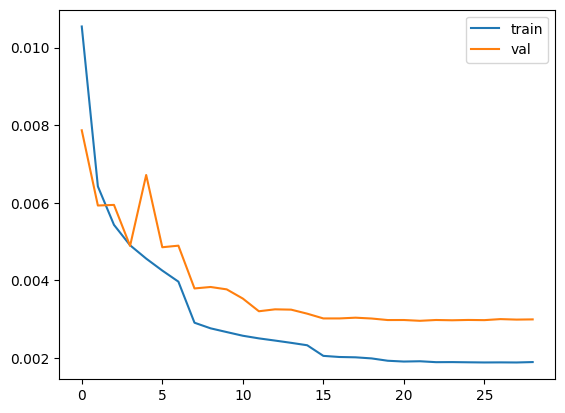

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.show()